In [13]:
import numpy as np
import pandas as pd
import scipy.stats as st
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor

from drtester import DRtester

### Generate Data

Setting with 5 continuous covariates, 2 categorical treatments (and a control), and a continous outcome. Treatment assignment is based on the covariates and random noise. The outcome is based on covariates, treatment, and random noise. For the second treatment, the effect is conditional on the second covariate (X[:, 1]).

In [14]:
np.random.seed(123)

N = 20000  # number of units
K = 5  # number of covariates
num_treatments = 2 # number of treatments (excluding control)

# Generate random Xs
X_mu = np.zeros(5)  # Means of Xs
# Random covariance matrix of Xs
X_sig = np.diag(np.random.rand(5))
X = st.multivariate_normal(X_mu, X_sig).rvs(N)

# Effect of Xs on outcome
X_beta = np.random.uniform(0, 5, K)
# Effect of treatment on outcomes
D_beta = np.array([0, 1, 2])
# Effect of treatment on outcome conditional on X1
DX1_beta = np.array([0, 0, 3])

# Generate treatments based on X and random noise
beta_treat = np.random.uniform(-1, 1, (num_treatments + 1, K))
D1 = np.zeros((N, num_treatments + 1))
for k in range(num_treatments + 1):
    D1[:, k] = X @ beta_treat[k, :] + np.random.gumbel(0, 1, N)
D = np.array([np.where(D1[i, :] == np.max(D1[i, :]))[0][0] for i in range(N)])
D_dum = pd.get_dummies(D)

# Generate Y (based on X, D, and random noise)
Y_sig = 1  # Variance of random outcome noise
Y = X @ X_beta + (D_dum @ D_beta) + X[:, 1] * (D_dum @ DX1_beta) + np.random.normal(0, Y_sig, N)
Y = Y.to_numpy()

# Split into training/validation samples
train_prop = .5
train_N = np.ceil(train_prop * N)
ind = np.array(range(N))
train_ind = np.random.choice(N, int(train_N), replace=False)
val_ind = ind[~np.isin(ind, train_ind)]

Xtrain, Dtrain, Ytrain = X[train_ind], D[train_ind], Y[train_ind]
Xval, Dval, Yval = X[val_ind], D[val_ind], Y[val_ind]

### Validation
We use a simple (un-tuned) random forest classifier to predict treatment and an un-tuned gradient boosted regressor both to predict outcomes and as the CATE model. In the true data, there is heterogeneity by the second covariate (X[:, 1]) for the second treatment (D = 2) but not for the first (D = 1). Therefore, we should see a significant blp_est, significant qini coefficient, and high calibration r-squared for the second treatment. We should see an insignificant blp estimate, lower qini coefficient, and lower calibration r-squared for the first treatment.

In [15]:
# Simple classifier and regressor for propensity, outcome, and cate
reg_t = RandomForestClassifier()
reg_y = GradientBoostingRegressor()
reg_cate = GradientBoostingRegressor()

In [16]:
# Initialize DRtester and fit/predict nuisance models
my_dr_tester = DRtester(reg_y, reg_t).fit_nuisance(Xval, Dval, Yval, Xtrain, Dtrain, Ytrain)

In [17]:
# Evaluate CATE model using all methods
Ztrain = Xtrain[:, 1]
Zval = Xval[:, 1]
my_dr_tester = my_dr_tester.evaluate_all(reg_cate, Zval, Ztrain)

In [18]:
print(my_dr_tester.df_res)

   treatment  blp_est  blp_se  blp_pval  qini_coeff  qini_se  qini_pval  \
0          1    0.045   0.045     0.314       0.042    0.021      0.024   
1          2    0.567   0.074     0.000       0.386    0.031      0.000   

   cal_r_squared  
0         -0.053  
1          0.802  


#### Plot Calibration

We can also plot the calibration for each treatment. There should be a strong positive relationship for treatment 2 but a flat relationship for treatment 1

<Axes: title={'center': 'Treatment = 1, Calibration R^2 = -0.053'}, xlabel='Group Mean CATE', ylabel='GATE'>

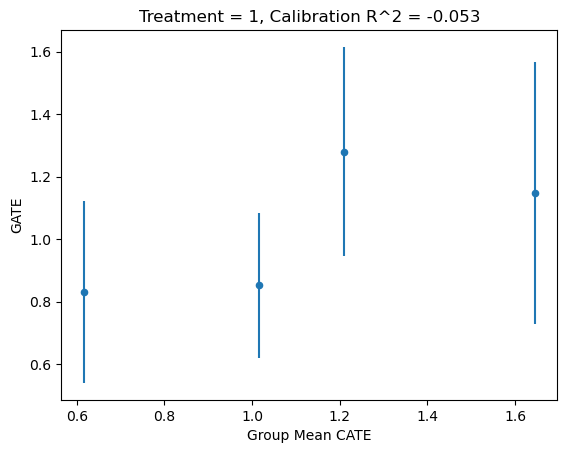

In [34]:
my_dr_tester.plot_cal(1)

<Axes: title={'center': 'Treatment = 2, Calibration R^2 = 0.802'}, xlabel='Group Mean CATE', ylabel='GATE'>

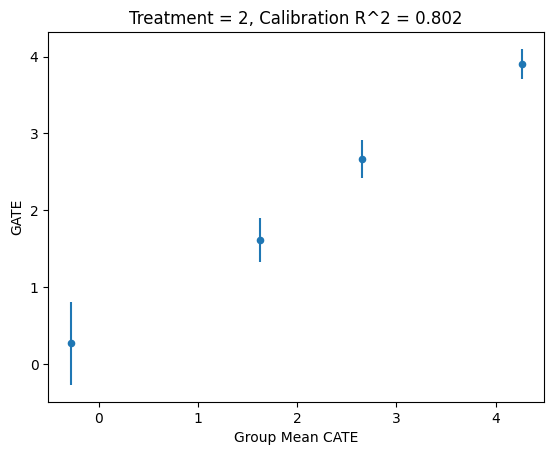

In [25]:
my_dr_tester.plot_cal(2)

### Testing different models

We can also fit nuisance models once and then examine a variety of different CATE models

In [35]:
# Simple classifier and regressor for propensity, outcome, and cate
reg_t = RandomForestClassifier()
reg_y = GradientBoostingRegressor()

# Initialize DRtester and fit/predict nuisance models
my_dr_tester = DRtester(reg_y, reg_t).fit_nuisance(Xval, Dval, Yval, Xtrain, Dtrain, Ytrain)

In [43]:
reg_cate_1 = GradientBoostingRegressor(learning_rate=0.1)
reg_cate_2 = GradientBoostingRegressor(learning_rate=1)

Ztrain = Xtrain[:, 1]
Zval = Xval[:, 1]

In [44]:
# Run the first CATE
my_dr_tester = my_dr_tester.evaluate_all(reg_cate_1, Zval, Ztrain)
print(my_dr_tester.df_res)

   treatment  blp_est  blp_se  blp_pval  qini_coeff  qini_se  qini_pval  \
0          1   -0.002   0.009     0.813       0.027    0.018      0.068   
1          2    0.211   0.090     0.020       0.399    0.024      0.000   

   cal_r_squared  
0         -0.864  
1          0.790  


In [45]:
# Run the second CATE
my_dr_tester = my_dr_tester.evaluate_all(reg_cate_2, Zval, Ztrain)
print(my_dr_tester.df_res)

   treatment  blp_est  blp_se  blp_pval  qini_coeff  qini_se  qini_pval  \
0          1   -0.000   0.004     0.919       0.011    0.018      0.267   
1          2    0.045   0.020     0.025       0.348    0.022      0.000   

   cal_r_squared  
0        -15.510  
1         -0.079  
